In [2]:
import pickle
import jax
import jax.numpy as jnp
import optax
from tqdm import tqdm
import e3nn_jax as e3nn
import chex
import os
import sys



# Add src directory to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_dir = os.path.join(project_root, 'src')
sys.path.append(src_dir)

from utils.plotters import visualize_geometry, colorplot, visualize_signal, compare_geometries
from utils.geometries import trigonal_plane, tetrahedron, octahedron, icosahedron, dodecahedron
from utils.alignment import sample_uniform_quaternion, align_signals, find_best_random_quaternion, rotate_points_quaternion, stack_points, point_distance, spherical_harmonic_distance, stack_points, choose_best_quaternion, evenly_distributed_quaternions, quaternion_rotation_distance, spherical_grid_distance
import spectra
from spectra import sum_of_diracs, powerspectrum, bispectrum, trispectrum, invert, reconstruct_geometry



jax.config.update('jax_enable_x64', True)
jax.config.update('jax_platform_name', 'cpu')
jax.config.update('jax_default_matmul_precision', 'high')

LMAX = 3

def sum_of_diracs(
    vectors: chex.Array, 
    lmax: int, 
    values: chex.Array = None
) -> e3nn.IrrepsArray:
    """
    Given a set of vectors, computes the sum of Dirac delta functions.

    Parameters:
        vectors (chex.Array): Input array of vectors.
        lmax (int): Maximum degree of spherical harmonics.
        values (chex.Array, optional): Values at each vector. 
            If not provided, the norm of each vector is used.

    Returns:
        e3nn.IrrepsArray: The sum of Dirac delta functions.
    """
    if values is None:
        values = jnp.linalg.norm(vectors, axis=1)
    return e3nn.sum(e3nn.s2_dirac(vectors, lmax, p_val=1, p_arg=-1) * values[:, None], axis=0)


def bispectrum(x: e3nn.IrrepsArray) -> jnp.ndarray:
    """
    Computes the bispectrum of an array of irreducible representations.

    Parameters:
        x (e3nn.IrrepsArray): Input array of irreps.

    Returns:
        jnp.ndarray: The bispectrum of the input array.
    """
    rtp = e3nn.reduced_symmetric_tensor_product_basis(x.irreps, 3, keep_ir=['0o', '0e'])
    return e3nn.IrrepsArray(rtp.irreps, jnp.einsum("i,j,k,ijkz->z", x.array, x.array, x.array, rtp.array)).array

@jax.jit
def invert_with_adam(true_bs, init_pts):
    lr = 1e-2
    opt = optax.adam(lr)
    state = opt.init(init_pts)
    def loss_fn(x):
        pred_bs = bispectrum(sum_of_diracs(x, LMAX))
        return jnp.mean(jnp.abs(true_bs - pred_bs))
    def step(carry, _):
        pts, st = carry
        g = jax.grad(loss_fn)(pts)
        updates, st = opt.update(g, st, pts)
        return (optax.apply_updates(pts, updates), st), None
    (final_pts, _), _ = jax.lax.scan(step, (init_pts, state), None, length=10000)
    return final_pts

def invert(bs, seed):
    key = jax.random.PRNGKey(seed)
    init_pts = jax.random.normal(key, (15,3), jnp.float64)
    final_pts = invert_with_adam(bs, init_pts)
    return final_pts

In [3]:
@jax.jit
def invert_with_adam_shs(true_bs, init_signal):
    lr = 1e-2
    opt = optax.adam(lr)
    state = opt.init(init_signal.array)
    
    def loss_fn(x):
        # Reconstruct the IrrepsArray from the array
        signal = e3nn.IrrepsArray(init_signal.irreps, x)
        # Compute bispectrum directly from the signal
        pred_bs = bispectrum(signal)
        return jnp.mean(jnp.abs(true_bs - pred_bs))
    
    def step(carry, _):
        signal_array, st = carry
        g = jax.grad(loss_fn)(signal_array)
        updates, st = opt.update(g, st, signal_array)
        return (optax.apply_updates(signal_array, updates), st), None
    
    (final_signal_array, _), _ = jax.lax.scan(step, (init_signal.array, state), None, length=10000)
    
    # Return as IrrepsArray
    return e3nn.IrrepsArray(init_signal.irreps, final_signal_array)

def invert_to_shs(bs, seed):
    key = jax.random.PRNGKey(seed)
    # Create a random spherical harmonic signal
    irreps_str = f"1x0e+1x1o+1x2e+1x3o"  # For LMAX=3
    init_signal = e3nn.IrrepsArray(irreps_str, jax.random.normal(key, (16,), jnp.float64))
    
    final_signal = invert_with_adam_shs(bs, init_signal)
    return final_signal.array

In [4]:
trigonal_plane = jnp.array([
    [0, 1, 0],
    [0.866, -0.5, 0],
    [-0.866, -0.5, 0]
])

trigonal_plane_shs = sum_of_diracs(trigonal_plane, LMAX)
trigonal_plane_bs = bispectrum(trigonal_plane_shs)

visualize_signal(trigonal_plane_shs)

In [18]:
sh_signals = []
for seed in tqdm(range(10000)):
    sh_signals.append(invert_to_shs(trigonal_plane_bs, seed))

100%|██████████| 10000/10000 [15:09<00:00, 10.99it/s]


In [19]:
true_rotated_sh_signals = []
for seed in tqdm(range(10000)):

    key = jax.random.PRNGKey(seed)
    ground_truth_quaternion = sample_uniform_quaternion(key)
    rotated_signal = trigonal_plane_shs.transform_by_quaternion(ground_truth_quaternion)
    true_rotated_sh_signals.append(rotated_signal.array)

100%|██████████| 10000/10000 [00:24<00:00, 402.47it/s]


In [71]:
sh_signals = jnp.array(sh_signals)
true_rotated_sh_signals = jnp.array(true_rotated_sh_signals)

train = jnp.concatenate([sh_signals, true_rotated_sh_signals], axis=0)

In [61]:
import numpy as np

irreps_str = f"1x0e+1x1o+1x2e+1x3o"  # For LMAX=3
bispectra_errors = []
for sh_signal_array in sh_signals:
    signal = e3nn.IrrepsArray(irreps_str, sh_signal_array)
    bis = bispectrum(signal)
    error = np.mean(np.abs(bis - trigonal_plane_bs))
    bispectra_errors.append(error)

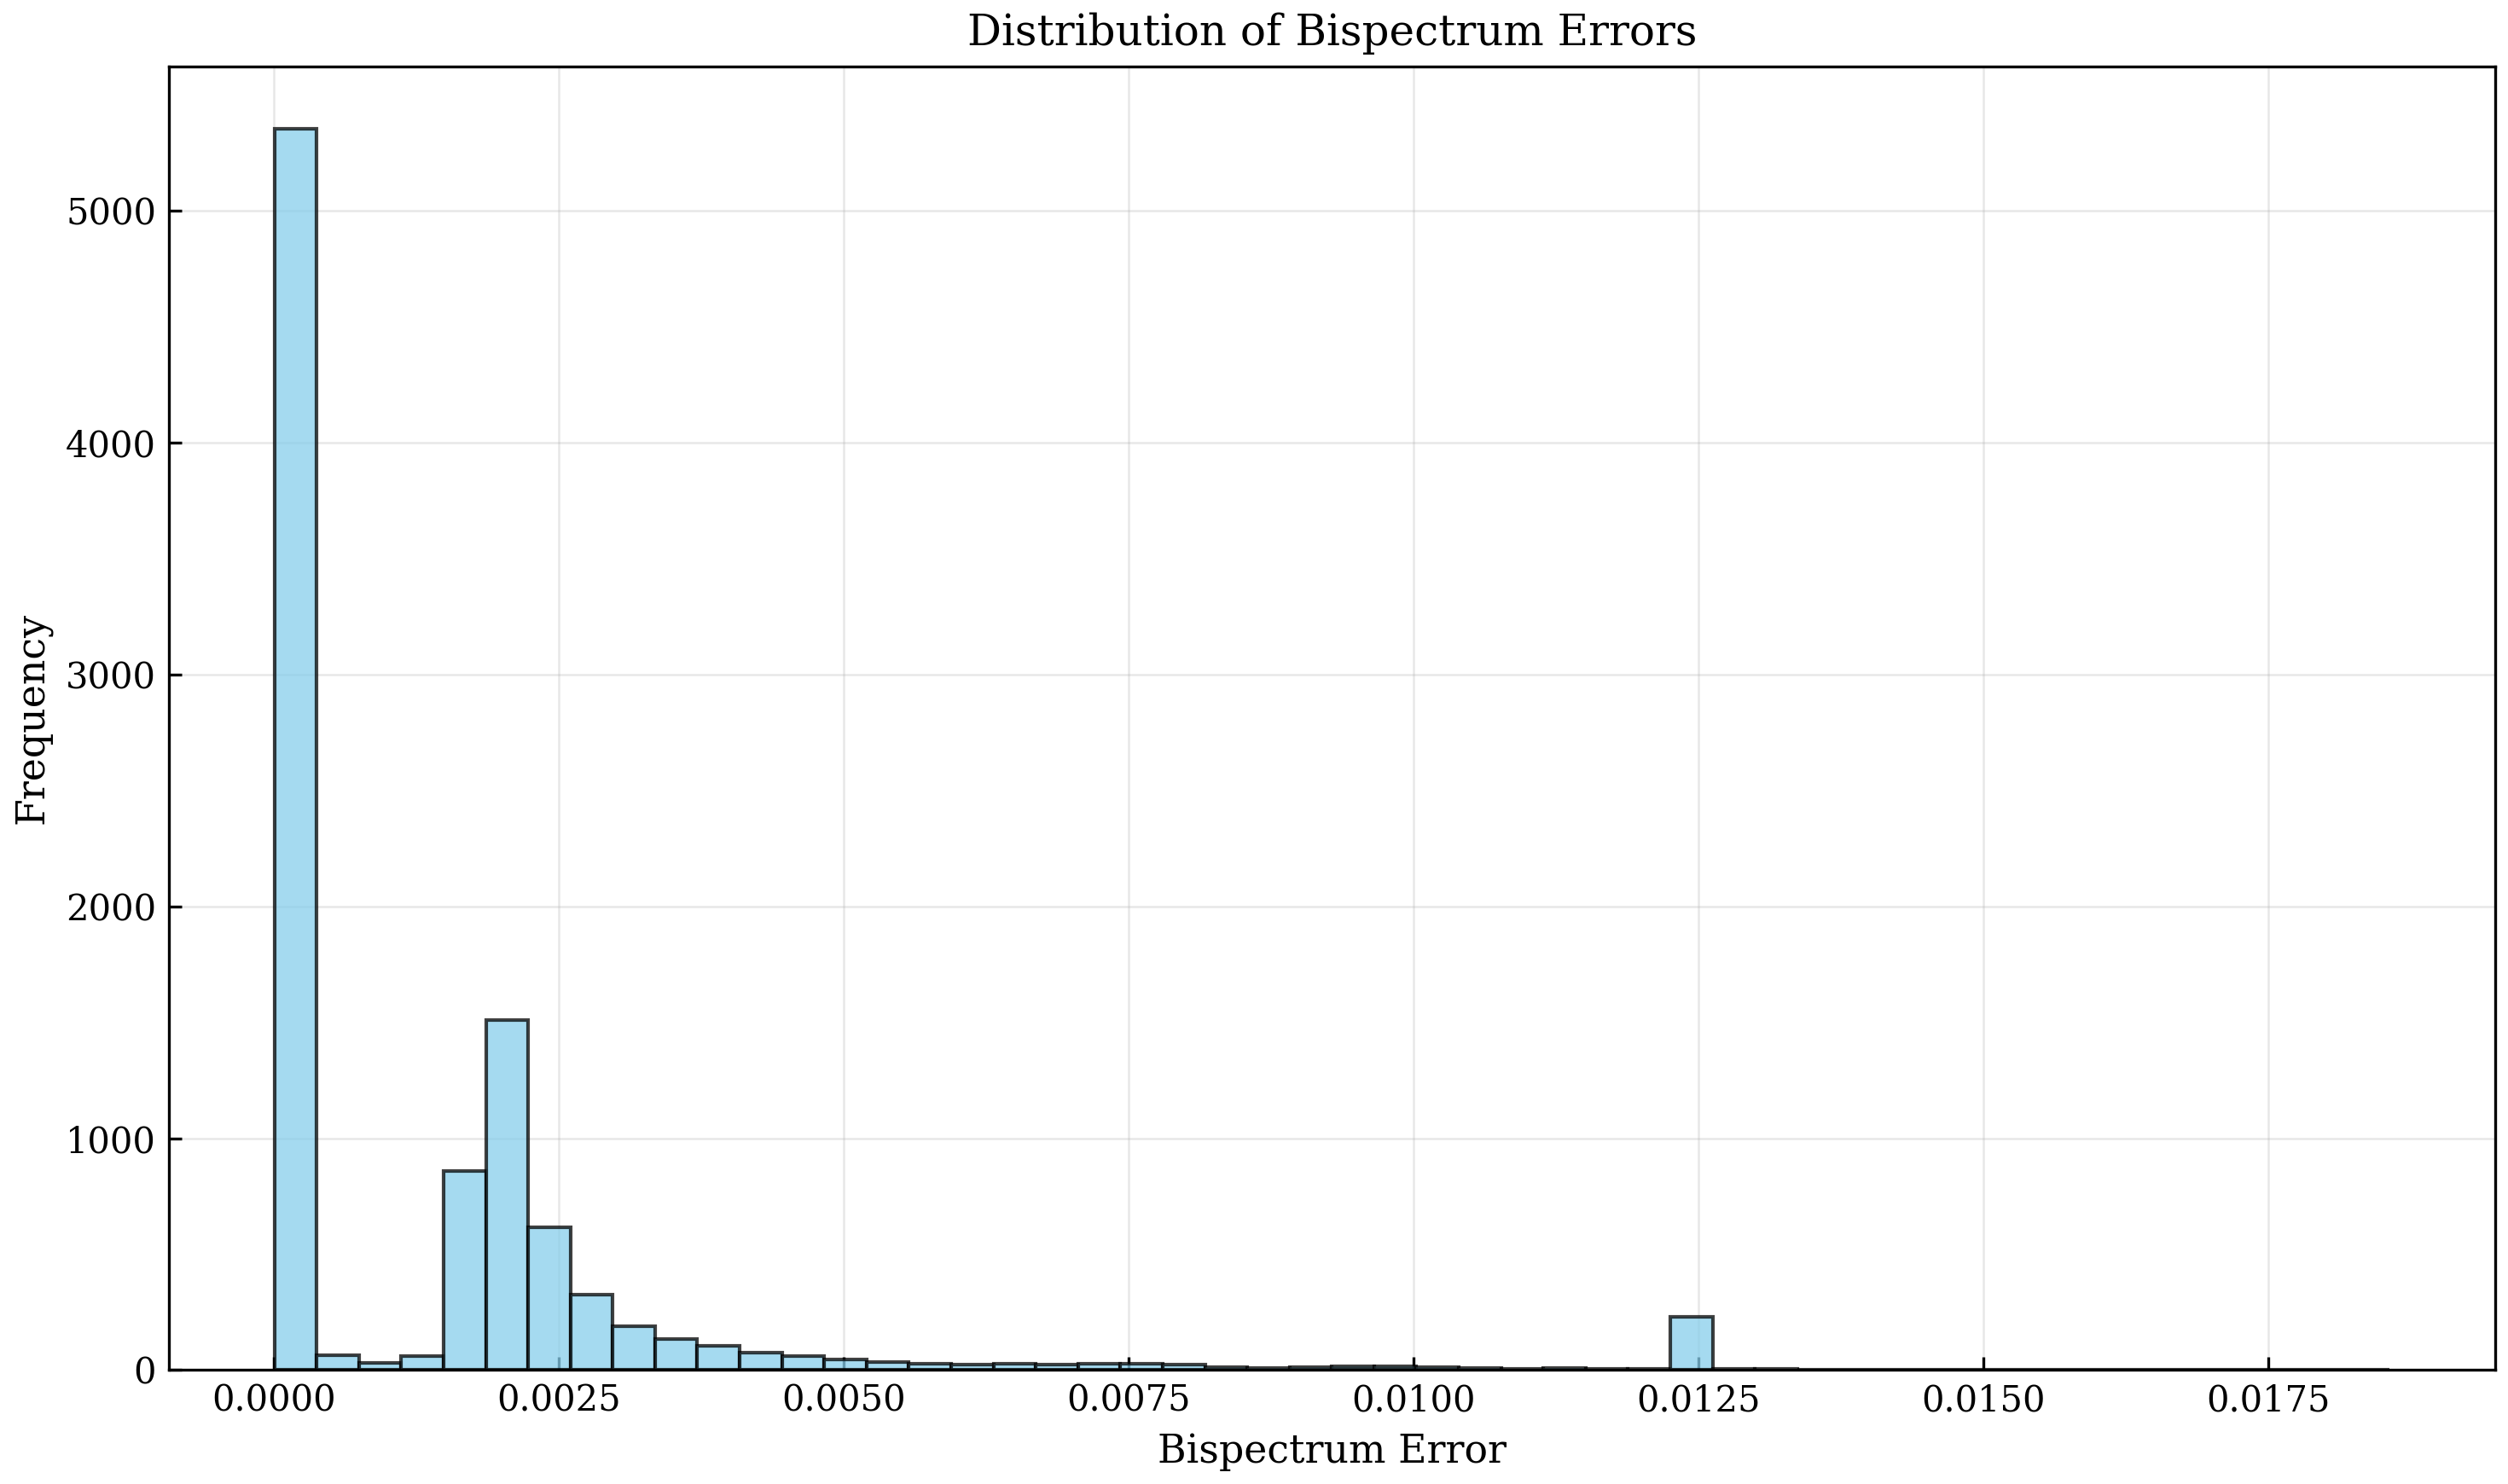

In [62]:
import matplotlib.pyplot as plt

# Create a histogram of the bispectrum errors
plt.figure(figsize=(10, 6))
plt.hist(bispectra_errors, bins=50, alpha=0.75, color='skyblue', edgecolor='black')
plt.xlabel('Bispectrum Error')
# plt.xscale('log')
plt.ylabel('Frequency')
plt.title('Distribution of Bispectrum Errors')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [63]:
# Count the number of entries in bispectra_errors with error < 0.001
low_error_count = sum(1 for error in bispectra_errors if error < 0.0001)
print(f"Number of signals with bispectrum error < 0.001: {low_error_count}")
print(f"Percentage of signals with bispectrum error < 0.001: {low_error_count / len(bispectra_errors) * 100:.2f}%")

# Find the minimum error
min_error = min(bispectra_errors)
print(f"Minimum bispectrum error: {min_error:.6f}")

# Define low_error_shs by filtering sh_signals based on bispectra_errors
low_error_indices = jnp.array([i for i, error in enumerate(bispectra_errors) if error < 0.0001])
low_error_shs = sh_signals[low_error_indices]
print(f"Number of low error SH signals: {len(low_error_shs)}")


Number of signals with bispectrum error < 0.001: 2243
Percentage of signals with bispectrum error < 0.001: 22.43%
Minimum bispectrum error: 0.000006
Number of low error SH signals: 2243


In [64]:
import numpy as np

irreps_str = f"1x0e+1x1o+1x2e+1x3o"  # For LMAX=3
bispectra_errors = []
for sh_signal_array in low_error_shs:
    signal = e3nn.IrrepsArray(irreps_str, sh_signal_array)
    bis = bispectrum(signal)
    error = np.mean(np.abs(bis - trigonal_plane_bs))
    bispectra_errors.append(error)

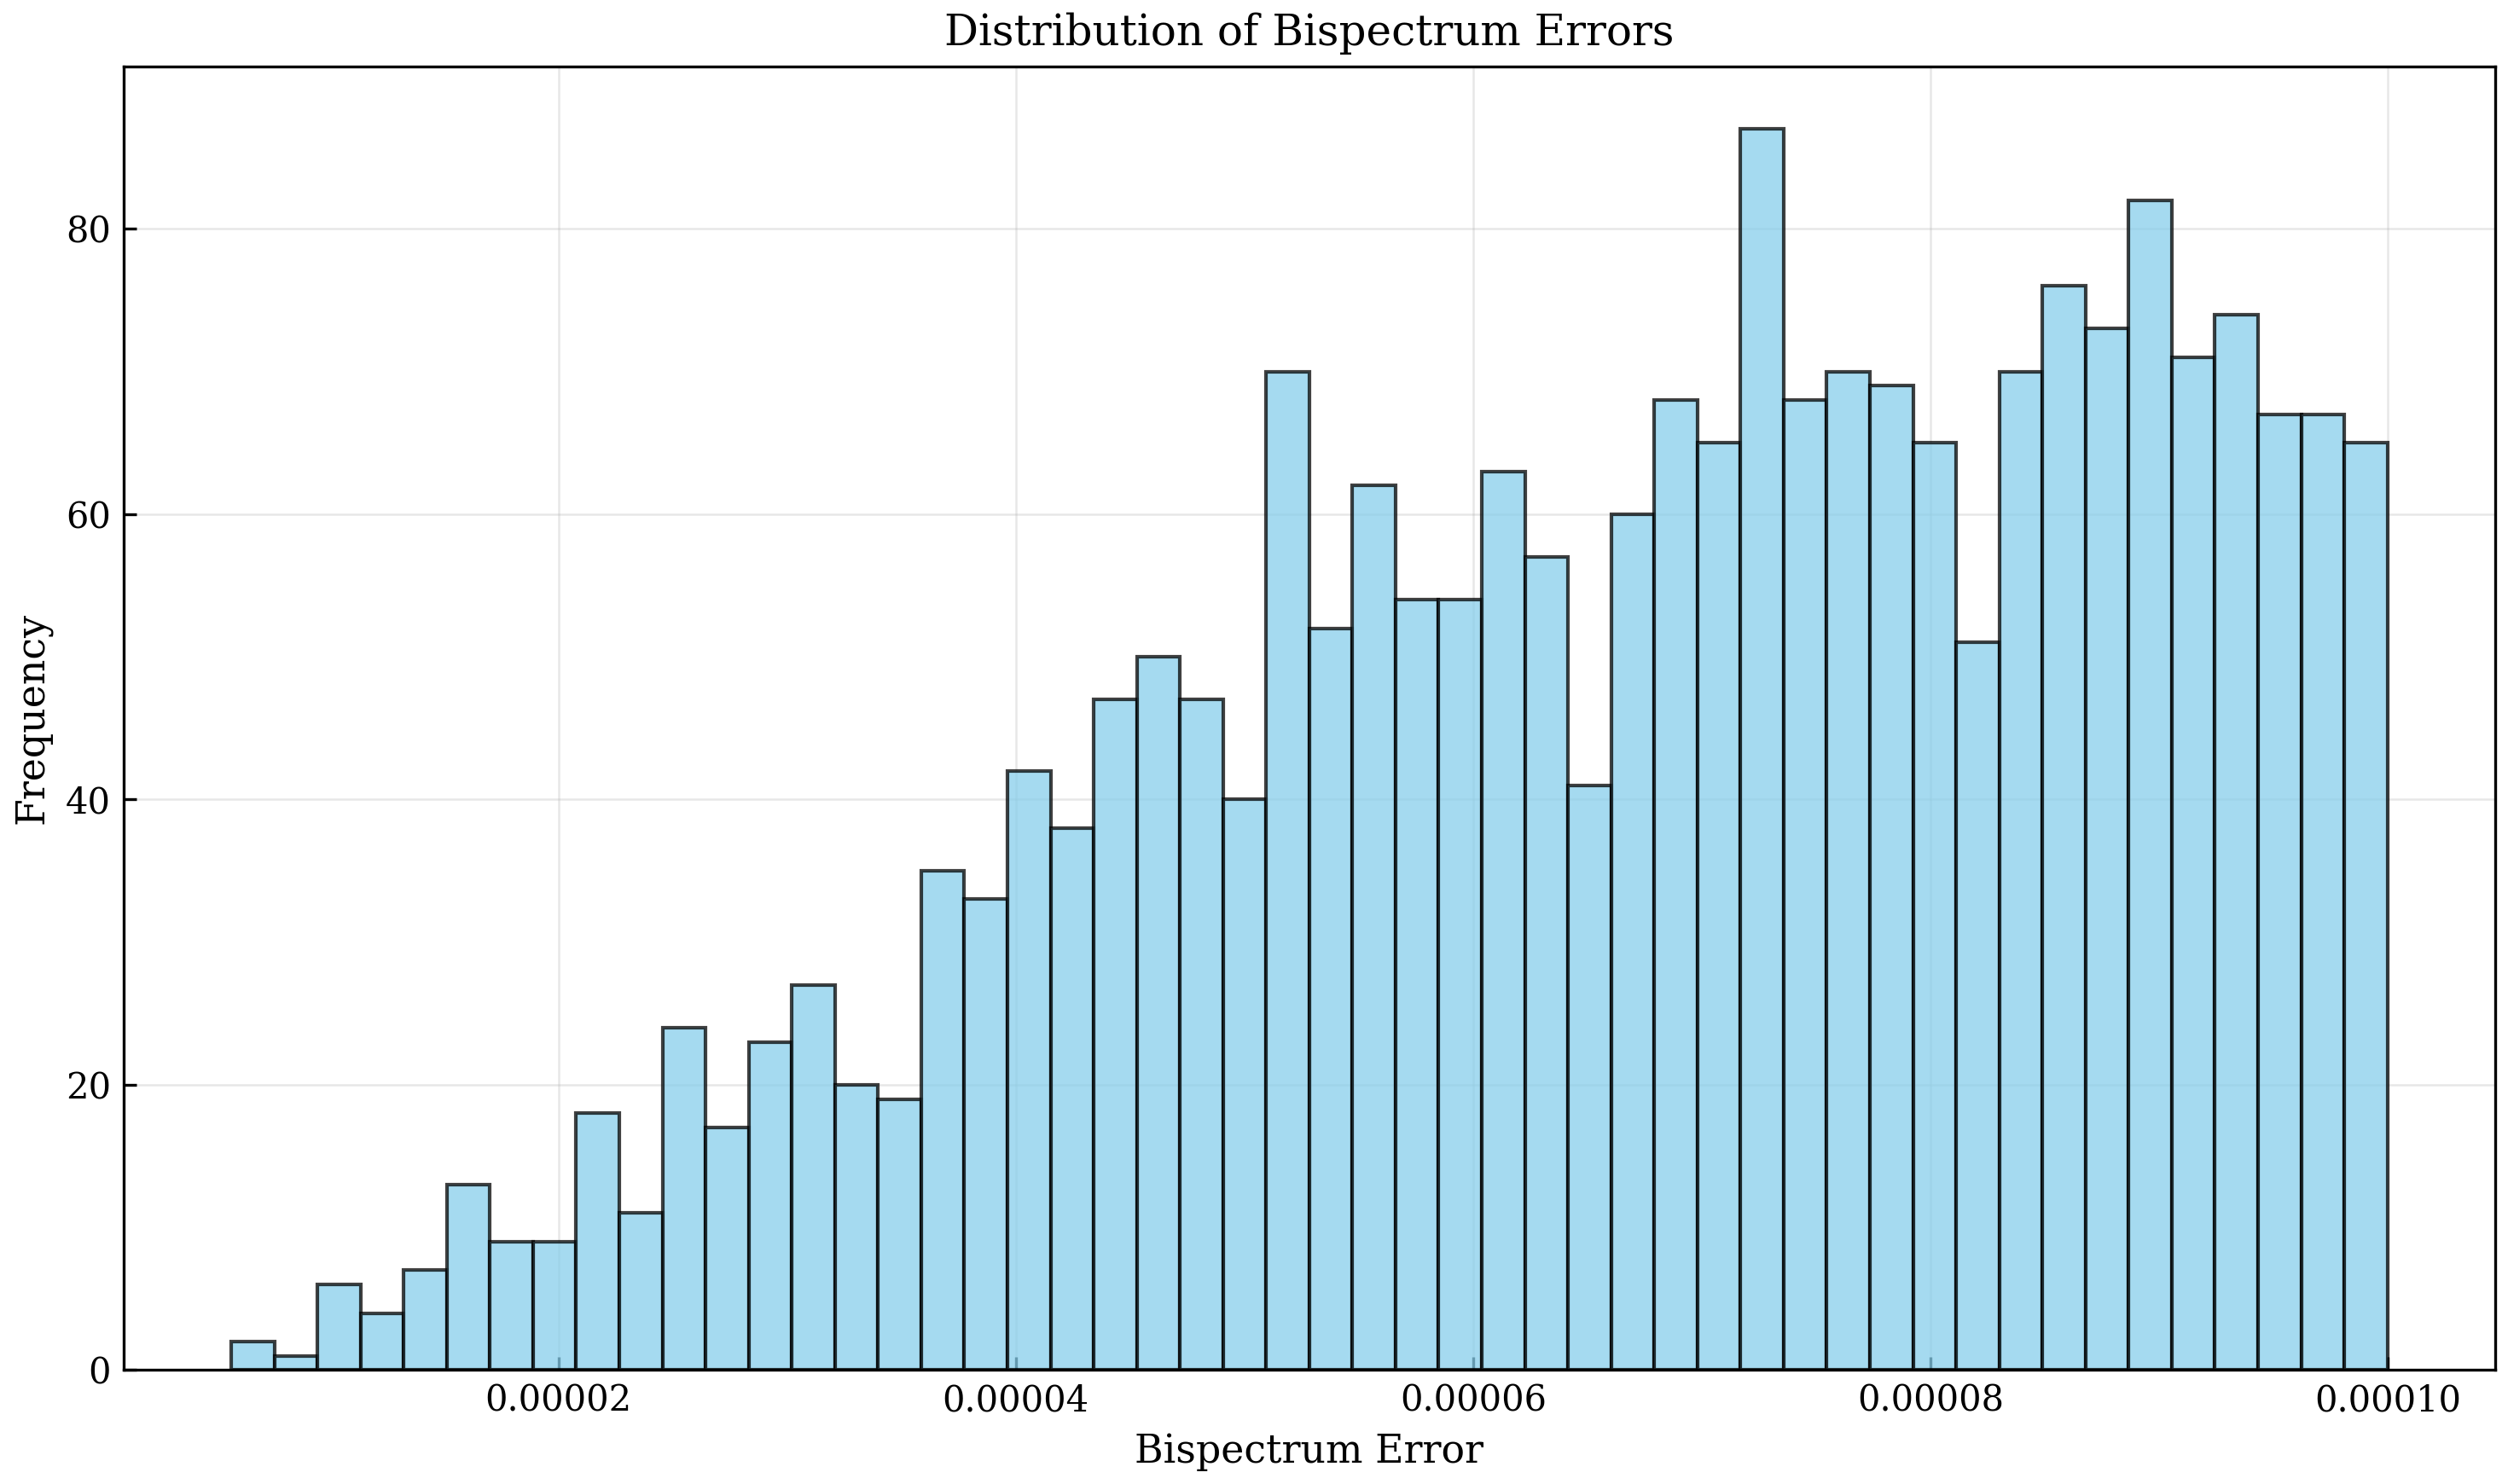

In [65]:
import matplotlib.pyplot as plt

# Create a histogram of the bispectrum errors
plt.figure(figsize=(10, 6))
plt.hist(bispectra_errors, bins=50, alpha=0.75, color='skyblue', edgecolor='black')
plt.xlabel('Bispectrum Error')
# plt.xscale('log')
plt.ylabel('Frequency')
plt.title('Distribution of Bispectrum Errors')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [66]:
train = jnp.concatenate([low_error_shs[:2000], true_rotated_sh_signals[:2000]], axis=0)

In [73]:
import jax
import jax.numpy as jnp
from jax import random, grad, jit
import flax.linen as nn
import optax
from flax.training import train_state
import numpy as np
from typing import Any, Dict
from functools import partial

# Set random seed for reproducibility
key = random.PRNGKey(42)

# Hyperparameters
input_dim = 16       # Length of bispectrum vectors
latent_dim = 2       # Dimension of the latent space
hidden_dim = 128     # Hidden layer dimension
batch_size = 256
learning_rate = 1e-3
num_epochs = 10000
kl_weight = 0      # Weight for KL regularization term

# Modified Autoencoder Model with separate encoder and decoder methods
class Autoencoder(nn.Module):
    hidden_dim: int
    latent_dim: int
    
    def setup(self):
        # Encoder layers
        self.encoder_layer1 = nn.Dense(self.hidden_dim)
        self.encoder_layer2 = nn.Dense(self.hidden_dim)
        self.encoder_output = nn.Dense(self.latent_dim)
        
        # Decoder layers
        self.decoder_layer1 = nn.Dense(self.hidden_dim)
        self.decoder_layer2 = nn.Dense(self.hidden_dim)
        self.decoder_output = nn.Dense(input_dim)
    
    def encode(self, x):
        x = self.encoder_layer1(x)
        x = nn.leaky_relu(x, negative_slope=0.2)
        x = self.encoder_layer2(x)
        x = nn.leaky_relu(x, negative_slope=0.2)
        return self.encoder_output(x)
    
    def decode(self, z):
        x = self.decoder_layer1(z)
        x = nn.leaky_relu(x, negative_slope=0.2)
        x = self.decoder_layer2(x)
        x = nn.leaky_relu(x, negative_slope=0.2)
        return self.decoder_output(x)
    
    def __call__(self, x):
        latent = self.encode(x)
        reconstructed = self.decode(latent)
        return reconstructed, latent

# Loss function with KL regularization (not JIT-compiled directly)
def loss_fn(params, batch, model):
    reconstructed, latent = model.apply({'params': params}, batch)
    
    # Reconstruction loss (MSE)
    recon_loss = jnp.mean(jnp.sum((reconstructed - batch) ** 2, axis=1))
    
    # KL divergence regularization
    kl_loss = 0.5 * jnp.mean(jnp.sum(latent ** 2 - jnp.log(latent ** 2 + 1e-8) - 1, axis=1))
    
    # Total loss
    total_loss = recon_loss + kl_weight * kl_loss
    
    return total_loss, (recon_loss, kl_loss)

# Create a non-JIT train step that we'll later partially apply with the model
def train_step_fn(model, state, batch):
    def loss_step(params):
        loss, (recon_loss, kl_loss) = loss_fn(params, batch, model)
        return loss, (recon_loss, kl_loss)
    
    grad_fn = jax.value_and_grad(loss_step, has_aux=True)
    (loss, (recon_loss, kl_loss)), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    
    return state, loss, recon_loss, kl_loss


# Prepare batches of data
def get_batches(data, batch_size, shuffle=True):
    num_samples = data.shape[0]
    indices = jnp.arange(num_samples)
    
    if shuffle:
        # Shuffle indices
        key = random.PRNGKey(0)
        indices = random.permutation(key, indices)
    
    # Create batches
    num_batches = num_samples // batch_size
    batches = []
    for i in range(num_batches):
        batch_indices = indices[i * batch_size:(i + 1) * batch_size]
        batches.append(data[batch_indices])
    
    return batches

# Main training function
def train_autoencoder(model, data, num_epochs, batch_size, learning_rate):
    # Initialize model parameters
    key = random.PRNGKey(0)
    dummy_input = jnp.ones((1, input_dim))
    params = model.init(key, dummy_input)['params']  # Extract only 'params'
    
    # Create optimizer
    tx = optax.adam(learning_rate)
    
    # Create training state (standard Flax training state without model)
    state = train_state.TrainState.create(
        apply_fn=None,  # Not needed since we use model.apply directly
        params=params,
        tx=tx
    )
    
    # Create a JIT-compiled step function by partially applying the model
    # This way the model is captured in the closure and isn't passed as a dynamic argument
    jitted_train_step = jit(partial(train_step_fn, model))
    
    # Prepare batches
    batches = get_batches(data, batch_size)
    
    # Training loop
    loss_history = {'total': [], 'recon': [], 'kl': []}
    
    for epoch in range(num_epochs):
        epoch_loss, epoch_recon_loss, epoch_kl_loss = 0.0, 0.0, 0.0
        
        for batch in batches:
            # Use the JIT-compiled function with the model already applied
            state, loss, recon_loss, kl_loss = jitted_train_step(state, batch)
            epoch_loss += loss
            epoch_recon_loss += recon_loss
            epoch_kl_loss += kl_loss
        
        # Average losses
        avg_loss = epoch_loss / len(batches)
        avg_recon_loss = epoch_recon_loss / len(batches)
        avg_kl_loss = epoch_kl_loss / len(batches)
        
        # Record history
        loss_history['total'].append(float(avg_loss))
        loss_history['recon'].append(float(avg_recon_loss))
        loss_history['kl'].append(float(avg_kl_loss))
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, '
                  f'Loss: {avg_loss}, '
                  f'Recon Loss: {avg_recon_loss}, '
                  f'KL Loss: {avg_kl_loss}')
    
    return state, loss_history, model

# Function to encode data
def encode_data(params, data, model):
    """Encode data into the latent space"""
    # Use the encode method directly
    latent = model.apply({'params': params}, data, method=model.encode)
    return latent

# New function to decode latents
def decode_data(params, latents, model):
    """Decode latent vectors back to original space"""
    # Use the decode method directly
    reconstructed = model.apply({'params': params}, latents, method=model.decode)
    return reconstructed

# Create model
model = Autoencoder(hidden_dim=hidden_dim, latent_dim=latent_dim)

# Load or generate data
data = train

print(f"Training Autoencoder with latent dimension {latent_dim}...")
state, loss_history, model = train_autoencoder(model, data, num_epochs, batch_size, learning_rate)

# Save model (using pickle or another method)
import pickle
with open('sh_autoencoder_model.pkl', 'wb') as f:
    pickle.dump({'params': state.params, 'loss_history': loss_history}, f)

print("Training complete. Model saved as 'sh_autoencoder_model.pkl'")

# Encode some examples to test
sample_data = data[:5]  # Get 5 samples
encoded_samples = encode_data(state.params, sample_data, model)
print("Example latent representations:")
print(encoded_samples)

# Decode the encoded samples to demonstrate round-trip
decoded_samples = decode_data(state.params, encoded_samples, model)
print("\nExample reconstructions (decoded from latents):")
print(decoded_samples)

# # You can also generate new samples by creating custom latent vectors
# custom_latent = jnp.array([[0.5, -0.3, 0.2, -0.1, 0.4, -0.2]])  # Custom latent vector
# generated_sample = decode_data(state.params, custom_latent, model)
# print("\nGenerated sample from custom latent vector:")
# print(generated_sample)

# Epoch 2000/10000, Loss: 0.33840802111895474, Recon Loss: 0.33840802111895474, KL Loss: 4.738731640077574


Training Autoencoder with latent dimension 2...
Epoch 10/10000, Loss: 0.8436254392408742, Recon Loss: 0.8436254392408742, KL Loss: 4.4650874937204525
Epoch 20/10000, Loss: 0.8058733086249414, Recon Loss: 0.8058733086249414, KL Loss: 4.3716407107004756
Epoch 30/10000, Loss: 0.7798105835445671, Recon Loss: 0.7798105835445671, KL Loss: 4.227153575442699
Epoch 40/10000, Loss: 0.7604473900246407, Recon Loss: 0.7604473900246407, KL Loss: 4.1404445355243995
Epoch 50/10000, Loss: 0.7538150571432003, Recon Loss: 0.7538150571432003, KL Loss: 4.05292127927713
Epoch 60/10000, Loss: 0.7278325379029987, Recon Loss: 0.7278325379029987, KL Loss: 4.044202668245198
Epoch 70/10000, Loss: 0.7208403364714159, Recon Loss: 0.7208403364714159, KL Loss: 4.015644165401451
Epoch 80/10000, Loss: 0.7154261703972046, Recon Loss: 0.7154261703972046, KL Loss: 3.9769656692890045
Epoch 90/10000, Loss: 0.7086418552559113, Recon Loss: 0.7086418552559113, KL Loss: 3.9453904874903185
Epoch 100/10000, Loss: 0.70005221789854

Encoding first dataset with 10000 data points to 2D latent space...


Encoding data: 100%|██████████| 10/10 [00:00<00:00, 99.35it/s]


Encoding second dataset with 10000 data points...


Encoding data: 100%|██████████| 10/10 [00:00<00:00, 124.61it/s]

Creating visualization...



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


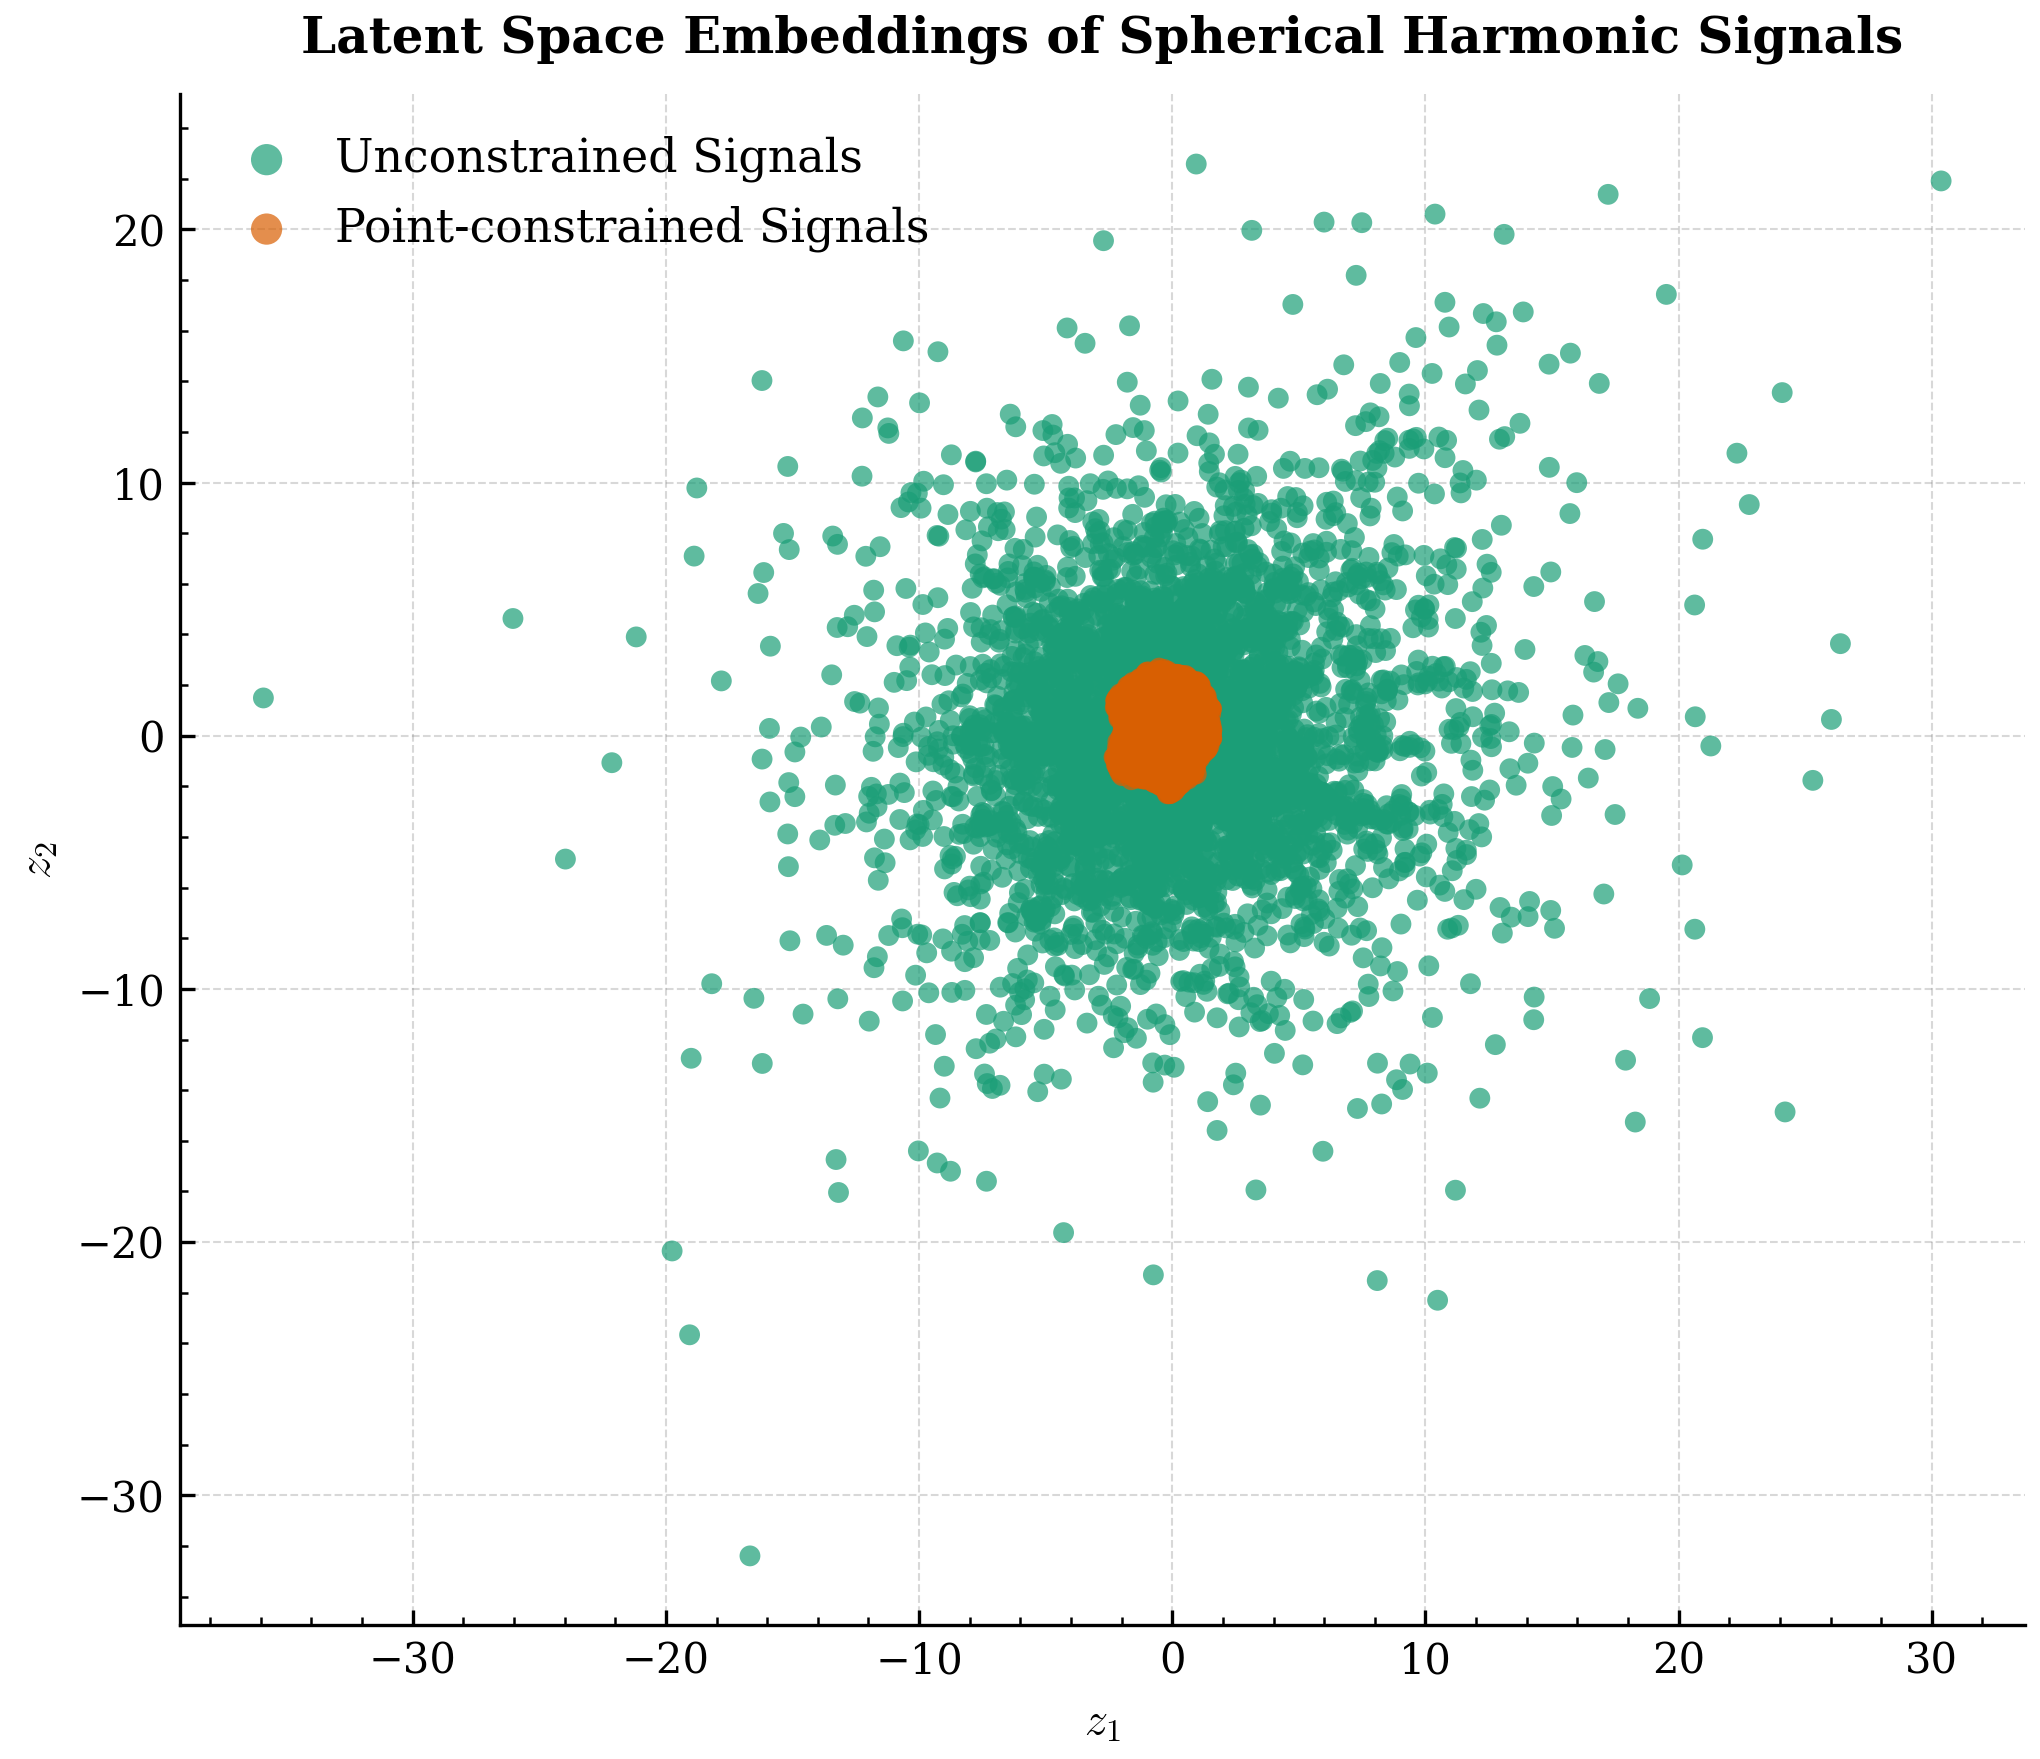

In [77]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.ticker as ticker

# Function to encode all data points using the trained model
def encode_all_data(params, data, model, batch_size=1024):
    """
    Encodes all data points in batches to avoid memory issues
    """
    num_samples = data.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size  # Ceiling division
    
    # Pre-allocate array for embeddings
    embeddings = np.zeros((num_samples, latent_dim))
    
    # Process in batches
    for i in tqdm(range(num_batches), desc="Encoding data"):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, num_samples)
        batch = data[start_idx:end_idx]
        
        # Get embeddings for this batch
        _, batch_embeddings = model.apply({'params': params}, batch)
        embeddings[start_idx:end_idx] = np.array(batch_embeddings)
    
    return embeddings

# Function to visualize 2D latent space - PUBLICATION QUALITY
def visualize_2d_latent_space(embeddings_1, embeddings_2=None, 
                             labels_1='Dataset 1', labels_2='Dataset 2',
                             colors_1='#1b9e77', colors_2='#d95f02',
                             alpha_1=0.7, alpha_2=0.7,
                             s_1=25, s_2=25,
                             save_path=None):
    """
    Visualizes a 2D latent space with publication-quality styling for academic papers.
    
    Args:
        embeddings_1: First set of embeddings with shape [n_samples, 2]
        embeddings_2: Optional second set of embeddings
        labels_1, labels_2: Labels for the datasets in the legend
        colors_1, colors_2: Colors for the datasets (using colorblind-friendly palette)
        alpha_1, alpha_2: Alpha values for transparency
        s_1, s_2: Sizes of the markers
        save_path: Optional path to save the figure
    """
    # Set publication-quality plot style
    plt.rcParams.update({
        'text.usetex': False,
        'font.family': 'serif',
        'font.serif': ['Computer Modern Roman', 'DejaVu Serif', 'Times New Roman'],
        'mathtext.fontset': 'cm',
        'axes.titlesize': 12,
        'axes.labelsize': 11,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'figure.dpi': 300,
        'savefig.dpi': 600,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.05,
        'axes.linewidth': 0.8,
        'grid.linewidth': 0.6,
        'lines.linewidth': 1.5,
        'lines.markersize': 5,
        'xtick.major.width': 0.8,
        'ytick.major.width': 0.8,
        'xtick.minor.width': 0.6,
        'ytick.minor.width': 0.6,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.major.size': 3.5,
        'ytick.major.size': 3.5,
        'xtick.minor.size': 2.0,
        'ytick.minor.size': 2.0,
        'axes.axisbelow': True,
        'axes.grid': False,
    })
    
    # Ensure embeddings are numpy arrays
    embeddings_1 = np.array(embeddings_1)
    
    # Check that embeddings have exactly 2 dimensions
    if embeddings_1.shape[1] != 2:
        raise ValueError(f"Expected embeddings with 2 dimensions, got {embeddings_1.shape[1]}")
    
    if embeddings_2 is not None:
        embeddings_2 = np.array(embeddings_2)
        if embeddings_2.shape[1] != 2:
            raise ValueError(f"Expected second embeddings with 2 dimensions, got {embeddings_2.shape[1]}")
    
    # Create single plot with the right size and aspect ratio
    fig, ax = plt.subplots(figsize=(7, 6))
    
    # Better dimension labels
    dim_names = ['$z_1$', '$z_2$']
    
    # Plot first dataset with enhanced styling
    scatter1 = ax.scatter(embeddings_1[:, 0], embeddings_1[:, 1], 
               color=colors_1, alpha=alpha_1, s=s_1, label=labels_1,
               edgecolors='none', rasterized=True)
    
    # Plot second dataset if provided
    if embeddings_2 is not None:
        scatter2 = ax.scatter(embeddings_2[:, 0], embeddings_2[:, 1], 
                   color=colors_2, alpha=alpha_2, s=s_2, label=labels_2,
                   edgecolors='none', rasterized=True)
    
    # Enhance axis formatting
    ax.grid(True, linestyle='--', alpha=0.3, color='gray', linewidth=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    
    # Set publication-quality axis labels
    ax.set_xlabel(dim_names[0], fontweight='normal')
    ax.set_ylabel(dim_names[1], fontweight='normal')
    ax.set_title('Latent Space Embeddings of Spherical Harmonic Signals', fontweight='bold', pad=10)
    
    # Add legend with better styling
    legend = ax.legend(loc='best', frameon=False, fontsize=11, 
                      handletextpad=0.5, markerscale=1.5)
    
    # Ensure plot has equal aspect ratio for proper 2D visualization
    ax.set_aspect('equal', adjustable='box')
    
    # Automatic axis limits with a small padding
    x_data = np.concatenate([embeddings_1[:, 0], 
                           embeddings_2[:, 0] if embeddings_2 is not None else np.array([])])
    y_data = np.concatenate([embeddings_1[:, 1], 
                           embeddings_2[:, 1] if embeddings_2 is not None else np.array([])])
    
    # Calculate boundaries with padding
    x_min, x_max = np.min(x_data), np.max(x_data)
    y_min, y_max = np.min(y_data), np.max(y_data)
    
    # Add 5% padding
    x_padding = 0.05 * (x_max - x_min)
    y_padding = 0.05 * (y_max - y_min)
    
    ax.set_xlim(x_min - x_padding, x_max + x_padding)
    ax.set_ylim(y_min - y_padding, y_max + y_padding)
    
    # Better layout
    plt.tight_layout()
    
    # Save in multiple formats suitable for publication
    if save_path:
        # Remove extension if present to add our own
        save_path = save_path.rsplit('.', 1)[0]
        plt.savefig(f"{save_path}.pdf", dpi=600, bbox_inches='tight')
        plt.savefig(f"{save_path}.png", dpi=600, bbox_inches='tight')
        plt.savefig(f"{save_path}.eps", format='eps', dpi=600, bbox_inches='tight')
    
    plt.show()
    
    return fig, ax

# Main visualization function for 2D latent space
def visualize_latent_space_2d(model_path, data_1, data_2=None, 
                             labels_1='Dataset 1', labels_2='Dataset 2',
                             colors_1='#1b9e77', colors_2='#d95f02',
                             save_path=None):
    """
    Main function to load model, encode data, and visualize 2D latent space
    with publication-quality styling
    """
    # Load model
    with open(model_path, 'rb') as f:
        model_data = pickle.load(f)
    
    params = model_data['params']
    
    # Create model architecture (same as during training)
    model = Autoencoder(hidden_dim=hidden_dim, latent_dim=2)  # Ensure latent_dim is 2
    
    print(f"Encoding first dataset with {data_1.shape[0]} data points to 2D latent space...")
    
    # Get embeddings for first dataset
    embeddings_1 = encode_all_data(params, data_1, model)
    
    # Get embeddings for second dataset if provided
    embeddings_2 = None
    if data_2 is not None:
        print(f"Encoding second dataset with {data_2.shape[0]} data points...")
        embeddings_2 = encode_all_data(params, data_2, model)
    
    print("Creating visualization...")
    
    # Visualize 2D latent space with publication styling
    fig, ax = visualize_2d_latent_space(
        embeddings_1, embeddings_2,
        labels_1=labels_1, labels_2=labels_2,
        colors_1=colors_1, colors_2=colors_2,
        save_path=save_path
    )
    
    return embeddings_1, embeddings_2, fig, ax

# Example usage:
embeddings_1, embeddings_2, fig, ax = visualize_latent_space_2d(
    'sh_autoencoder_model.pkl',
    data_1=jnp.array(sh_signals),
    data_2=jnp.array(true_rotated_sh_signals),
    labels_1='Unconstrained Signals',
    labels_2='Point-constrained Signals',
    save_path='latent_space_2d'
)

Encoding 1000 data points to 3D latent space...


Encoding data: 100%|██████████| 1/1 [00:00<00:00, 36.23it/s]

Computing PCA and creating visualizations...


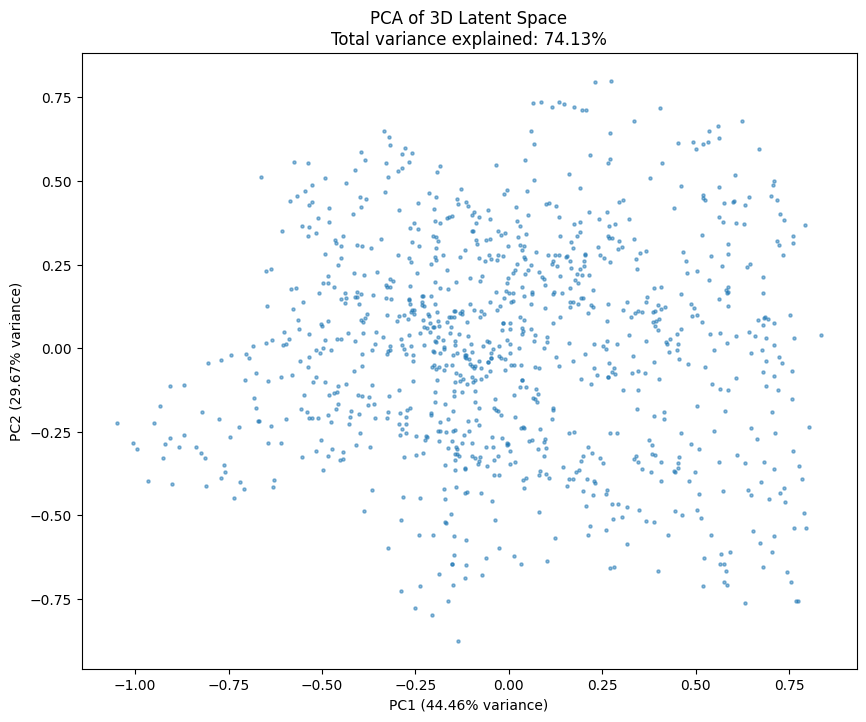

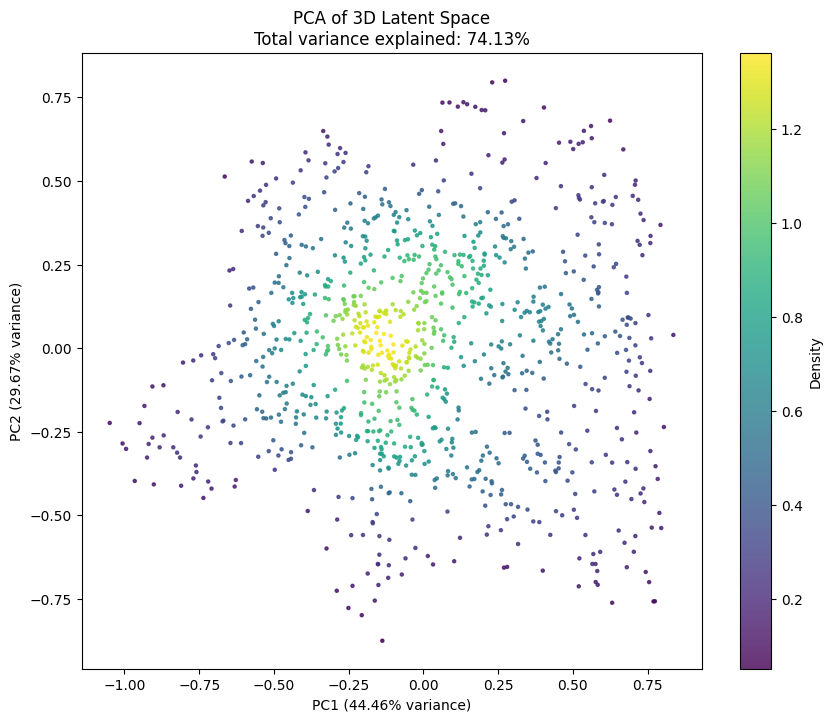

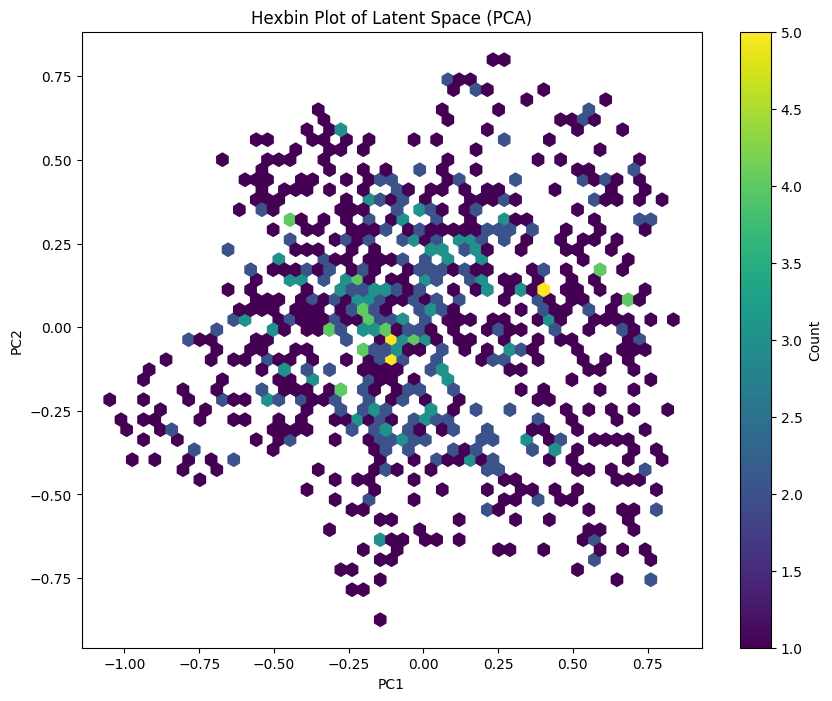

Top 2 principal components:
PC1: [-0.44793473  0.47775947  0.75571183]
PC2: [ 0.57279506  0.80235383 -0.16773238]


In [15]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from tqdm import tqdm
import pickle

# Function to encode all data points using the trained model
def encode_all_data(params, data, model, batch_size=1024):
    """
    Encodes all data points in batches to avoid memory issues
    """
    num_samples = data.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size  # Ceiling division
    
    # Pre-allocate array for embeddings
    embeddings = np.zeros((num_samples, latent_dim))
    
    # Process in batches
    for i in tqdm(range(num_batches), desc="Encoding data"):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, num_samples)
        batch = data[start_idx:end_idx]
        
        # Get embeddings for this batch
        _, batch_embeddings = model.apply({'params': params}, batch)
        embeddings[start_idx:end_idx] = np.array(batch_embeddings)
    
    return embeddings

# Function to compute and visualize PCA
def visualize_latent_space_pca(embeddings, save_path=None):
    """
    Computes PCA with 2 components and creates a scatter plot
    """
    # Apply PCA
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    
    # Compute explained variance
    explained_variance = pca.explained_variance_ratio_
    total_variance = sum(explained_variance) * 100
    
    # Create scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5, s=5)
    
    # Add labels and title
    plt.xlabel(f"PC1 ({explained_variance[0]:.2%} variance)")
    plt.ylabel(f"PC2 ({explained_variance[1]:.2%} variance)")
    plt.title(f"PCA of {latent_dim}D Latent Space\nTotal variance explained: {total_variance:.2f}%")
    
    # Add colorbar for density
    from scipy.stats import gaussian_kde
    xy = np.vstack([embeddings_2d[:, 0], embeddings_2d[:, 1]])
    density = gaussian_kde(xy)(xy)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                c=density, s=5, cmap='viridis', alpha=0.8)
    plt.colorbar(label='Density')
    
    # Add labels and title
    plt.xlabel(f"PC1 ({explained_variance[0]:.2%} variance)")
    plt.ylabel(f"PC2 ({explained_variance[1]:.2%} variance)")
    plt.title(f"PCA of {latent_dim}D Latent Space\nTotal variance explained: {total_variance:.2f}%")
    
    # Save if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return embeddings_2d, pca

# Function to visualize with 2D hexbin plot (alternative visualization)
def visualize_latent_space_hexbin(embeddings_2d, save_path=None):
    """
    Creates a hexbin plot for better visualization of dense regions
    """
    plt.figure(figsize=(10, 8))
    hb = plt.hexbin(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                   gridsize=50, cmap='viridis', mincnt=1)
    plt.colorbar(hb, label='Count')
    
    # Add labels
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Hexbin Plot of Latent Space (PCA)")
    
    # Save if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

# Main visualization function
def visualize_latent_space(model_path, data, save_path=None):
    """
    Main function to load model, encode data, and visualize latent space
    """
    # Load model
    with open(model_path, 'rb') as f:
        model_data = pickle.load(f)
    
    params = model_data['params']
    
    # Create model architecture (same as during training)
    model = Autoencoder(hidden_dim=hidden_dim, latent_dim=latent_dim)
    
    print(f"Encoding {data.shape[0]} data points to {latent_dim}D latent space...")
    
    # Get embeddings for all data points
    embeddings = encode_all_data(params, data, model)
    
    print("Computing PCA and creating visualizations...")
    
    # Visualize using PCA
    embeddings_2d, pca = visualize_latent_space_pca(embeddings, save_path)
    
    # Alternative visualization using hexbin
    visualize_latent_space_hexbin(embeddings_2d, 
                                 save_path.replace('.png', '_hexbin.png') if save_path else None)
    
    # Print top principal components
    print("Top 2 principal components:")
    for i, component in enumerate(pca.components_[:2]):
        print(f"PC{i+1}: {component}")
    
    return embeddings, embeddings_2d, pca

embeddings, embeddings_2d, pca = visualize_latent_space('sh_autoencoder_model.pkl', data=jnp.array(true_rotated_sh_signals))

Encoding first dataset with 2000 data points to 3D latent space...


Encoding data: 100%|██████████| 2/2 [00:00<00:00, 50.68it/s]


Encoding second dataset with 2000 data points...


Encoding data: 100%|██████████| 2/2 [00:00<00:00, 110.19it/s]

Creating visualizations...


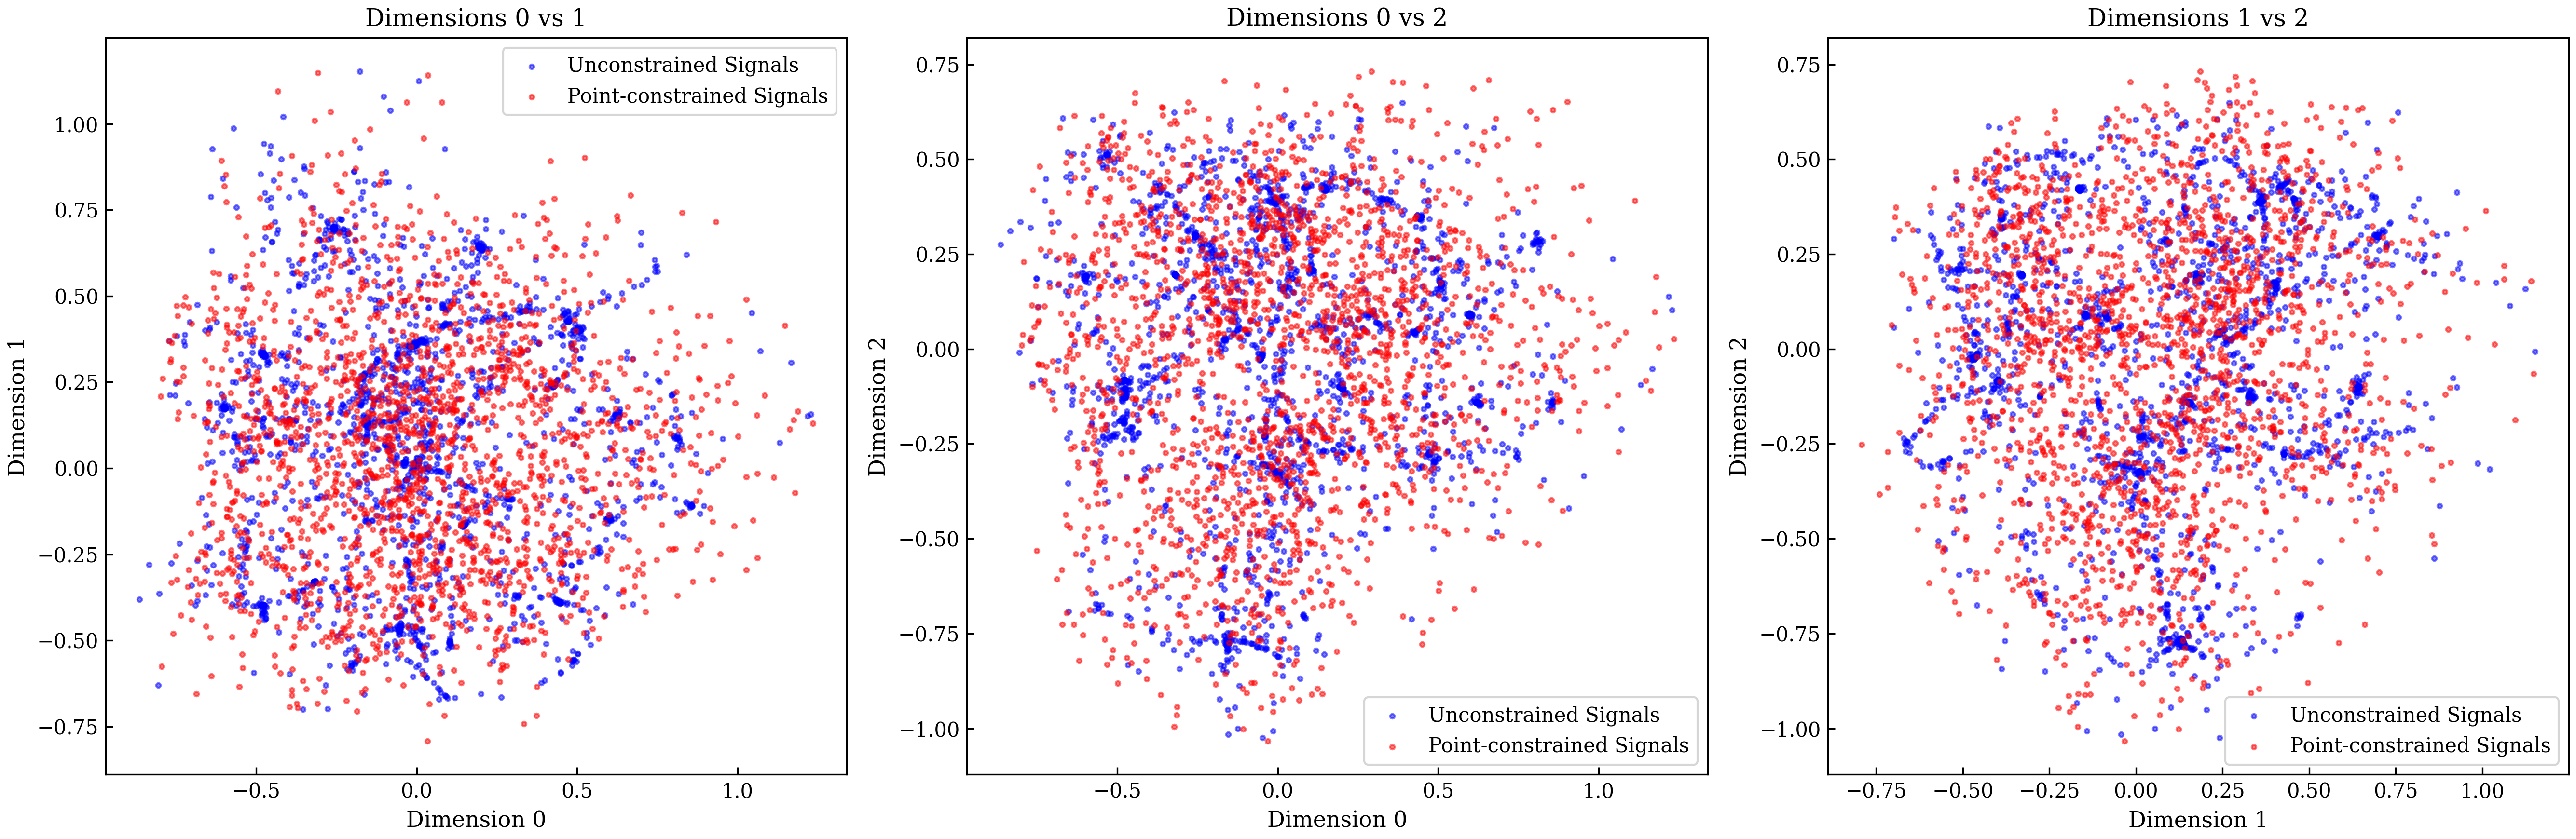

In [70]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pickle

# Function to encode all data points using the trained model
def encode_all_data(params, data, model, batch_size=1024):
    """
    Encodes all data points in batches to avoid memory issues
    """
    num_samples = data.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size  # Ceiling division
    
    # Pre-allocate array for embeddings
    embeddings = np.zeros((num_samples, latent_dim))
    
    # Process in batches
    for i in tqdm(range(num_batches), desc="Encoding data"):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, num_samples)
        batch = data[start_idx:end_idx]
        
        # Get embeddings for this batch
        _, batch_embeddings = model.apply({'params': params}, batch)
        embeddings[start_idx:end_idx] = np.array(batch_embeddings)
    
    return embeddings

# Function to visualize 3D latent space with pairwise 2D plots
def visualize_3d_latent_space(embeddings_1, embeddings_2=None, 
                             labels_1='Dataset 1', labels_2='Dataset 2',
                             colors_1='blue', colors_2='red',
                             alpha_1=0.5, alpha_2=0.5,
                             s_1=5, s_2=5,
                             save_path=None):
    """
    Visualizes a 3D latent space by creating three 2D plots for each pair of dimensions.
    Can visualize two different datasets with different colors.
    
    Args:
        embeddings_1: First set of embeddings with shape [n_samples, 3]
        embeddings_2: Optional second set of embeddings
        labels_1, labels_2: Labels for the datasets in the legend
        colors_1, colors_2: Colors for the datasets
        alpha_1, alpha_2: Alpha values for transparency
        s_1, s_2: Sizes of the markers
        save_path: Optional path to save the figure
    """
    # Ensure embeddings are numpy arrays
    embeddings_1 = np.array(embeddings_1)
    
    # Check that embeddings have exactly 3 dimensions
    if embeddings_1.shape[1] != 3:
        raise ValueError(f"Expected embeddings with 3 dimensions, got {embeddings_1.shape[1]}")
    
    if embeddings_2 is not None:
        embeddings_2 = np.array(embeddings_2)
        if embeddings_2.shape[1] != 3:
            raise ValueError(f"Expected second embeddings with 3 dimensions, got {embeddings_2.shape[1]}")
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Dimension pairs to plot
    dim_pairs = [(0, 1), (0, 2), (1, 2)]
    
    for i, (dim1, dim2) in enumerate(dim_pairs):
        ax = axes[i]
        
        # Plot first dataset
        ax.scatter(embeddings_1[:, dim1], embeddings_1[:, dim2], 
                   color=colors_1, alpha=alpha_1, s=s_1, label=labels_1)
        
        # Plot second dataset if provided
        if embeddings_2 is not None:
            ax.scatter(embeddings_2[:, dim1], embeddings_2[:, dim2], 
                       color=colors_2, alpha=alpha_2, s=s_2, label=labels_2)
        
        ax.set_xlabel(f"Dimension {dim1}")
        ax.set_ylabel(f"Dimension {dim2}")
        ax.set_title(f"Dimensions {dim1} vs {dim2}")
        ax.legend()
    
    plt.tight_layout()
    
    # Save if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return fig, axes

# Main visualization function for 3D latent space
def visualize_latent_space_3d(model_path, data_1, data_2=None, 
                             labels_1='Dataset 1', labels_2='Dataset 2',
                             colors_1='blue', colors_2='red',
                             save_path=None):
    """
    Main function to load model, encode data, and visualize 3D latent space
    Can handle two different datasets with different colors
    """
    # Load model
    with open(model_path, 'rb') as f:
        model_data = pickle.load(f)
    
    params = model_data['params']
    
    # Create model architecture (same as during training)
    model = Autoencoder(hidden_dim=hidden_dim, latent_dim=latent_dim)
    
    print(f"Encoding first dataset with {data_1.shape[0]} data points to {latent_dim}D latent space...")
    
    # Get embeddings for first dataset
    embeddings_1 = encode_all_data(params, data_1, model)
    
    # Get embeddings for second dataset if provided
    embeddings_2 = None
    if data_2 is not None:
        print(f"Encoding second dataset with {data_2.shape[0]} data points...")
        embeddings_2 = encode_all_data(params, data_2, model)
    
    print("Creating visualizations...")
    
    # Visualize 3D latent space
    fig, axes = visualize_3d_latent_space(
        embeddings_1, embeddings_2,
        labels_1=labels_1, labels_2=labels_2,
        colors_1=colors_1, colors_2=colors_2,
        save_path=save_path
    )
    
    return embeddings_1, embeddings_2, fig, axes

# Example usage:
# For a single dataset:
# embeddings_1, _, fig, axes = visualize_latent_space_3d(
#     'sh_autoencoder_model.pkl', 
#     data_1=jnp.array(true_rotated_sh_signals),
#     save_path='latent_space_3d.png'
# )

# For two datasets:
embeddings_1, embeddings_2, fig, axes = visualize_latent_space_3d(
    'sh_autoencoder_model.pkl',
    data_1=jnp.array(low_error_shs[:2000]),
    data_2=jnp.array(true_rotated_sh_signals[:2000]),
    labels_1='Unconstrained Signals',
    labels_2='Point-constrained Signals',
    colors_1='blue',
    colors_2='red',
    save_path='latent_space_comparison.png'
)

Encoding first dataset with 10000 data points to 3D latent space...


Encoding data: 100%|██████████| 10/10 [00:00<00:00, 65.25it/s]


Encoding second dataset with 10000 data points...


Encoding data: 100%|██████████| 10/10 [00:00<00:00, 135.29it/s]


Creating visualizations...


/var/folders/7c/7cx32s8x1x32j9xw0z_x3y980000gn/T/ipykernel_4876/3512502318.py:137: UserWarning:

The figure layout has changed to tight

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


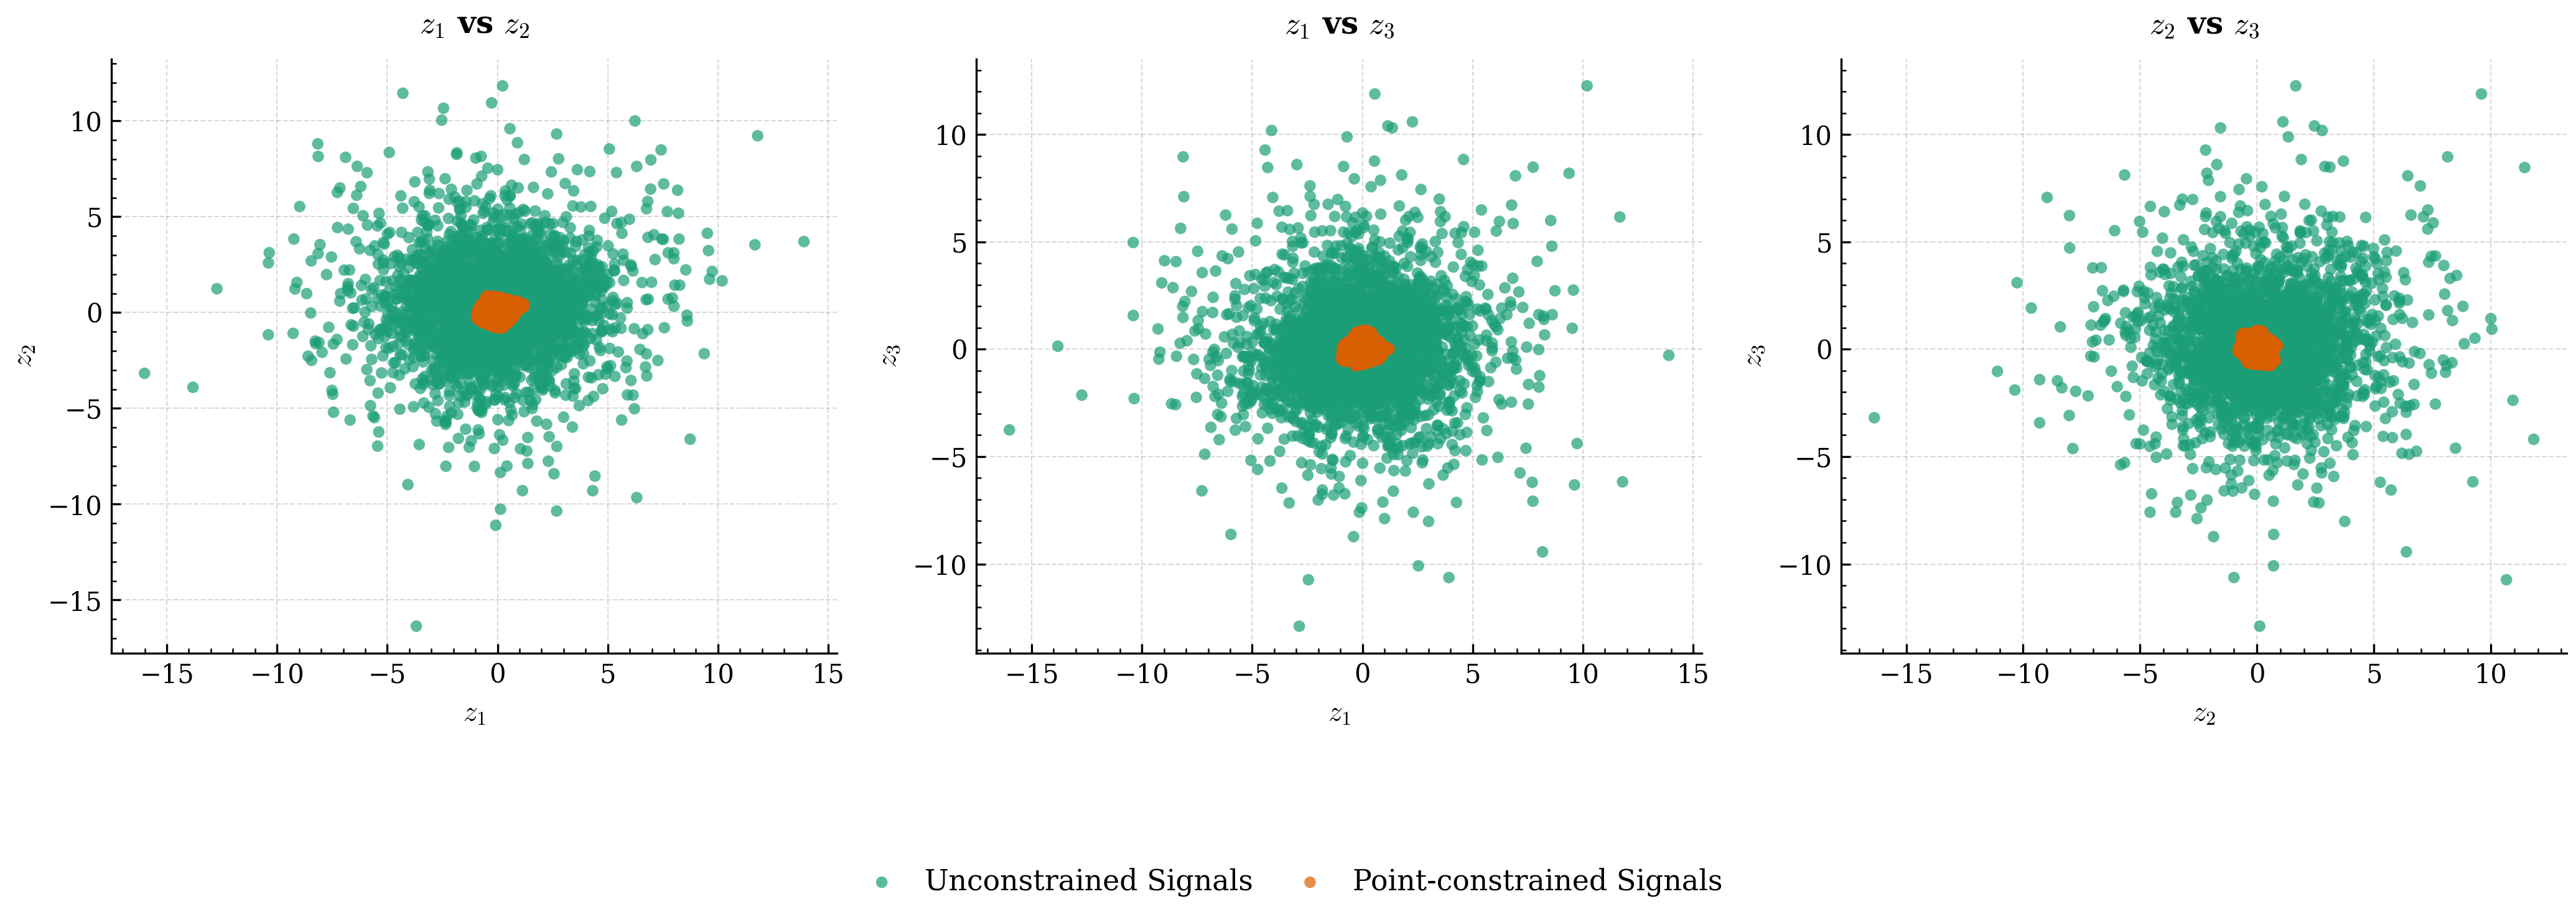

In [31]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.ticker as ticker

# Function to encode all data points using the trained model
def encode_all_data(params, data, model, batch_size=1024):
    """
    Encodes all data points in batches to avoid memory issues
    """
    num_samples = data.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size  # Ceiling division
    
    # Pre-allocate array for embeddings
    embeddings = np.zeros((num_samples, latent_dim))
    
    # Process in batches
    for i in tqdm(range(num_batches), desc="Encoding data"):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, num_samples)
        batch = data[start_idx:end_idx]
        
        # Get embeddings for this batch
        _, batch_embeddings = model.apply({'params': params}, batch)
        embeddings[start_idx:end_idx] = np.array(batch_embeddings)
    
    return embeddings

# Function to visualize 3D latent space with pairwise 2D plots - PUBLICATION QUALITY
def visualize_3d_latent_space(embeddings_1, embeddings_2=None, 
                             labels_1='Dataset 1', labels_2='Dataset 2',
                             colors_1='#1b9e77', colors_2='#d95f02',
                             alpha_1=0.7, alpha_2=0.7,
                             s_1=20, s_2=20,
                             save_path=None):
    """
    Visualizes a 3D latent space by creating three 2D plots for each pair of dimensions.
    Publication-quality styling for academic papers.
    
    Args:
        embeddings_1: First set of embeddings with shape [n_samples, 3]
        embeddings_2: Optional second set of embeddings
        labels_1, labels_2: Labels for the datasets in the legend
        colors_1, colors_2: Colors for the datasets (using colorblind-friendly palette)
        alpha_1, alpha_2: Alpha values for transparency
        s_1, s_2: Sizes of the markers
        save_path: Optional path to save the figure
    """
    # Set publication-quality plot style
    plt.rcParams.update({
        'text.usetex': False,  # Don't use LaTeX for text rendering
        'font.family': 'serif',
        'font.serif': ['Computer Modern Roman', 'DejaVu Serif', 'Times New Roman'],
        'mathtext.fontset': 'cm',  # Still use Computer Modern for math
        'axes.titlesize': 12,
        'axes.labelsize': 11,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'figure.dpi': 300,
        'savefig.dpi': 600,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.05,
        'axes.linewidth': 0.8,
        'grid.linewidth': 0.6,
        'lines.linewidth': 1.5,
        'lines.markersize': 5,
        'xtick.major.width': 0.8,
        'ytick.major.width': 0.8,
        'xtick.minor.width': 0.6,
        'ytick.minor.width': 0.6,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.major.size': 3.5,
        'ytick.major.size': 3.5,
        'xtick.minor.size': 2.0,
        'ytick.minor.size': 2.0,
        'axes.axisbelow': True,
        'axes.grid': False,
    })
    
    # Ensure embeddings are numpy arrays
    embeddings_1 = np.array(embeddings_1)
    
    # Check that embeddings have exactly 3 dimensions
    if embeddings_1.shape[1] != 3:
        raise ValueError(f"Expected embeddings with 3 dimensions, got {embeddings_1.shape[1]}")
    
    if embeddings_2 is not None:
        embeddings_2 = np.array(embeddings_2)
        if embeddings_2.shape[1] != 3:
            raise ValueError(f"Expected second embeddings with 3 dimensions, got {embeddings_2.shape[1]}")
    
    # Create figure with 3 subplots with proper spacing
    fig, axes = plt.subplots(1, 3, figsize=(14, 4.5), constrained_layout=True)
    
    # Dimension pairs to plot
    dim_pairs = [(0, 1), (0, 2), (1, 2)]
    dim_names = ['$z_1$', '$z_2$', '$z_3$']  # Better dimension labels
    
    for i, (dim1, dim2) in enumerate(dim_pairs):
        ax = axes[i]
        
        # Plot first dataset with enhanced styling
        scatter1 = ax.scatter(embeddings_1[:, dim1], embeddings_1[:, dim2], 
                   color=colors_1, alpha=alpha_1, s=s_1, label=labels_1,
                   edgecolors='none', rasterized=True)  # Better for publication
        
        # Plot second dataset if provided
        if embeddings_2 is not None:
            scatter2 = ax.scatter(embeddings_2[:, dim1], embeddings_2[:, dim2], 
                       color=colors_2, alpha=alpha_2, s=s_2, label=labels_2,
                       edgecolors='none', rasterized=True)
        
        # Enhance axis formatting
        ax.grid(True, linestyle='--', alpha=0.3, color='gray', linewidth=0.5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
        
        # Set publication-quality axis labels
        ax.set_xlabel(dim_names[dim1], fontweight='normal')
        ax.set_ylabel(dim_names[dim2], fontweight='normal')
        ax.set_title(f"{dim_names[dim1]} vs {dim_names[dim2]}", fontweight='bold', pad=10)
    
    # Add a single legend outside the plots with better styling
    handles, labels = ax.get_legend_handles_labels()
    legend = fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.12),
                      fancybox=False, shadow=False, ncol=2, frameon=False,
                      fontsize=11, handletextpad=0.5, columnspacing=1.0)
    
    # Adjust layout for the legend
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)
    
    # Save in multiple formats suitable for publication
    if save_path:
        # Remove extension if present to add our own
        save_path = save_path.rsplit('.', 1)[0]
        plt.savefig(f"{save_path}.pdf", dpi=600, bbox_inches='tight')
        plt.savefig(f"{save_path}.png", dpi=600, bbox_inches='tight')
        plt.savefig(f"{save_path}.eps", format='eps', dpi=600, bbox_inches='tight')
    
    plt.show()
    
    return fig, axes

# Main visualization function for 3D latent space
def visualize_latent_space_3d(model_path, data_1, data_2=None, 
                             labels_1='Dataset 1', labels_2='Dataset 2',
                             colors_1='#1b9e77', colors_2='#d95f02',
                             save_path=None):
    """
    Main function to load model, encode data, and visualize 3D latent space
    with publication-quality styling
    """
    # Load model
    with open(model_path, 'rb') as f:
        model_data = pickle.load(f)
    
    params = model_data['params']
    
    # Create model architecture (same as during training)
    model = Autoencoder(hidden_dim=hidden_dim, latent_dim=latent_dim)
    
    print(f"Encoding first dataset with {data_1.shape[0]} data points to {latent_dim}D latent space...")
    
    # Get embeddings for first dataset
    embeddings_1 = encode_all_data(params, data_1, model)
    
    # Get embeddings for second dataset if provided
    embeddings_2 = None
    if data_2 is not None:
        print(f"Encoding second dataset with {data_2.shape[0]} data points...")
        embeddings_2 = encode_all_data(params, data_2, model)
    
    print("Creating visualizations...")
    
    # Visualize 3D latent space with publication styling
    fig, axes = visualize_3d_latent_space(
        embeddings_1, embeddings_2,
        labels_1=labels_1, labels_2=labels_2,
        colors_1=colors_1, colors_2=colors_2,
        save_path=save_path
    )
    
    return embeddings_1, embeddings_2, fig, axes

# Example usage:
embeddings_1, embeddings_2, fig, axes = visualize_latent_space_3d(
    'sh_autoencoder_model.pkl',
    data_1=jnp.array(sh_signals),
    data_2=jnp.array(true_rotated_sh_signals),
    labels_1='Unconstrained Signals',
    labels_2='Point-constrained Signals',
    save_path='latent_space_comparison'
)

In [1]:
raise Error

NameError: name 'Error' is not defined

In [35]:
from tqdm import tqdm



def invert(bs):

    master_rng = jax.random.PRNGKey(0)

    best_loss = np.inf
    best_geometry = None

    for _ in range(20):
        # 1) split RNG, sample a fresh init
        master_rng, subkey = jax.random.split(master_rng)
        init_pts = jax.random.normal(subkey, (15,3), jnp.float64)

        # 2) first inversion
        final_pts = invert_with_adam(bs, init_pts, num_iters=10000)

        # 3) cluster the result
        stacked = stack_points(np.array(final_pts))

        # 4) second inversion on clustered points
        if stacked.shape[0] > 0:
            pred_geometry = invert_with_adam(bs, stacked, num_iters=10000)
            loss = np.mean(np.abs(compute_bispectrum_for(pred_geometry) - bs))
        else:
            loss = np.inf


        # 5) keep if best
        if loss < best_loss:
            best_loss = loss
            best_geometry = pred_geometry

    return best_geometry


def get_errors(geometries):
    bispectra = [compute_bispectrum_for(geometry) for geometry in geometries]
    encoded_samples = encode_data(state.params, bispectra, model)
    decoded_samples = decode_data(state.params, encoded_samples, model)
    errors = []
    for i in tqdm(range(len(decoded_samples))):
        reconstructed_geometry = invert(decoded_samples[i])
        errors.append(alignment_mae(geometries[i], reconstructed_geometry))
    return errors

results = get_errors(test_geometries)

100%|██████████| 100/100 [3:14:12<00:00, 116.53s/it] 


99


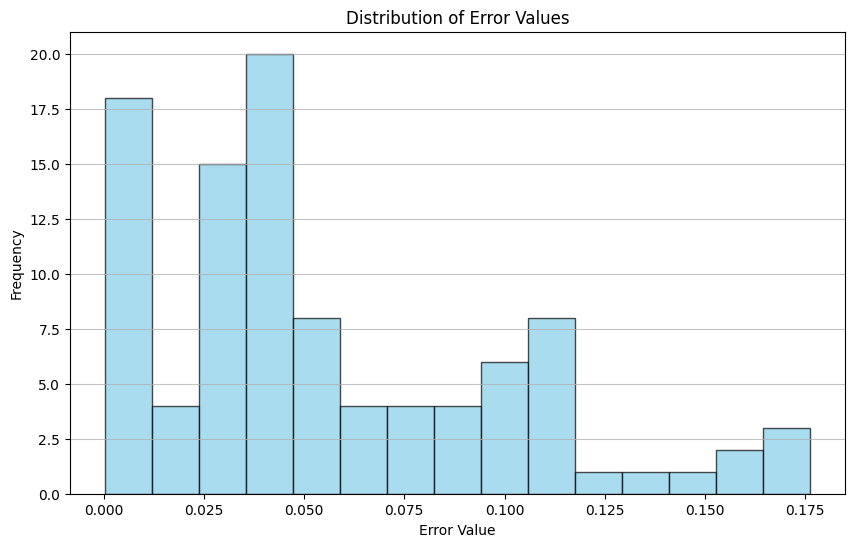

0.055671568778763114


In [37]:
invalid_count = 0

for result in results: 
    if type(result) == tuple:
        invalid_count += 1

print(invalid_count)

errors = [result[0] for result in results if type(result) == tuple]

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=15, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Error Values')
plt.xlabel('Error Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

print(np.mean(errors))

In [36]:
# Save the results to a file
import pickle

# Define the filename
results_filename = 'qm9_autoencoder_results_2_points.pkl'

# Save the results using pickle
with open(results_filename, 'wb') as f:
    pickle.dump(results, f)

print(f"Results saved to {results_filename}")

# If you need to load the results later, you can use:
# with open(results_filename, 'rb') as f:
#     loaded_results = pickle.load(f)


Results saved to qm9_autoencoder_results_2_points.pkl
